# Определение перспективного тарифа для телеком-компании

**ПЛАН РАБОТЫ:**  

**1. Подготовка данных:**
- получение первичной информации о данных
- объединение всех датасетов в один
- поиск ошибок в данных
- поиск дубликатов, пропущенных значений
- приведение к нужным типам данных  

**2. Расчет параметров для каждого пользователя:**  

- количество сделанных звонков и израсходованных минут разговора по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам
- помесячную выручку с каждого пользователя  

**3. Анализ показателей (количество минут и сообщений, объем интернет-трафика):** 

- расчет средних, медиан
- построение гистограмм
- расчет статистических параметров выборки (дисперсия, стандартное отклонение)

**4. Проверка гипотез:**

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

**5. Общий вывод по проекту** 

## Подготовка данных

### Получение первичной информации о данных

In [1]:
import pandas as pd #импортируем библиотеки
import numpy as np
import matplotlib.pyplot as plt 
import math
from scipy import stats as st

In [2]:
calls = pd.read_csv("calls.csv")
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
internet.pop('Unnamed: 0') # удалим столбец с дублирующими индексами

0              0
1              1
2              2
3              3
4              4
           ...  
149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, Length: 149396, dtype: int64

In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [8]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Сразу заменим 'mb_per_month_included' на 'gb_per_month_included' для дальнейшего удобства.

In [11]:
tariffs = tariffs.rename(columns={'mb_per_month_included' : 'gb_per_month_included'})
tariffs['gb_per_month_included'] = tariffs['gb_per_month_included'] / 1024
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


In [12]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [14]:
calls['duration'] = calls['duration'].apply('ceil').astype('int')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


### Объединение всех датасетов в один

Объединение таблиц calls, internet, messages проводится по столбцу id (уникальный номер звонка, сообщения, интернет-сессии), так как столбец id содержит идентификационный номер пользователя и через '_' числовую последовательность от 0 до числа звонков, сообщений, сессий (смотря какой параметр из трех больше), так как объединение идет с параметром 'outer'.  
Последнее объединение идет  стаблицей users по столбцу user_id

In [15]:
df = calls.merge(messages, how='outer').merge(internet, how='outer').merge(users, how='right')
df.head()

,id,call_date,duration,user_id,message_date,mb_used,session_date,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,2018-07-25,0.0,1000,2018-06-27,112.95,2018-11-25,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,2018-08-17,0.0,1000,2018-10-08,1052.81,2018-09-07,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,2018-06-11,3.0,1000,2018-08-04,1197.26,2018-06-25,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,2018-09-21,14.0,1000,2018-06-16,550.27,2018-08-22,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,2018-12-15,6.0,1000,2018-12-05,302.56,2018-09-24,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237281 entries, 0 to 237280
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            237279 non-null  object 
 1   call_date     202607 non-null  object 
 2   duration      202607 non-null  float64
 3   user_id       237281 non-null  int64  
 4   message_date  123036 non-null  object 
 5   mb_used       149396 non-null  float64
 6   session_date  149396 non-null  object 
 7   age           237281 non-null  int64  
 8   churn_date    11187 non-null   object 
 9   city          237281 non-null  object 
 10  first_name    237281 non-null  object 
 11  last_name     237281 non-null  object 
 12  reg_date      237281 non-null  object 
 13  tariff        237281 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 27.2+ MB


### Поиск ошибок в данных, удаление/замена значений, изменение форматов

**Для меня открытым до сих пор остается вопрос, нужно ли удалять NaN**, или заменять их на опредленное число, ведь математические операции можно проводить с NaN, они не должны помешать. Просто нет подходящих значений для замены, например в столбце duration, ведь если мы заменим NaN на 0, что вроде бы логично, то не сможем отличить от пропущенных звонков, которые имеют значение 0.  
В случаях интернет-сессий можем заменить пропущенные значения в столбце mb_used на 0, так как скорее всего отсутствие информации о них говорит о том, что человек не заходил в интернет.

In [17]:
df['mb_used'] = df['mb_used'].fillna(0) # заменим NaN на 0

In [18]:
df['duration'] = df['duration'].fillna(0) # заменим NaN на 0

Изменим тип данных в столбцах call_date, message_date, session_date, churn_date, reg_date на формат даты, чтобы затем мы могли обращаться к году, месяцу, дню, если это будет необходимо.

In [19]:
columns_to_change = ['call_date', 'message_date', 'session_date', 'churn_date', 'reg_date']
df[columns_to_change] = df[columns_to_change].apply(pd.to_datetime, format='%Y-%m-%d')

Также имеет смысл удалить из таблицы неактивных абонентов (не звонили, не писали, не сидели в интернете). Таких всего двое, удалим их.

In [20]:
df = df[~(df['call_date'].isna() 
          & df['message_date'].isna() 
          & df['session_date'].isna())]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237279 entries, 0 to 237280
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            237279 non-null  object        
 1   call_date     202607 non-null  datetime64[ns]
 2   duration      237279 non-null  float64       
 3   user_id       237279 non-null  int64         
 4   message_date  123036 non-null  datetime64[ns]
 5   mb_used       237279 non-null  float64       
 6   session_date  149396 non-null  datetime64[ns]
 7   age           237279 non-null  int64         
 8   churn_date    11185 non-null   datetime64[ns]
 9   city          237279 non-null  object        
 10  first_name    237279 non-null  object        
 11  last_name     237279 non-null  object        
 12  reg_date      237279 non-null  datetime64[ns]
 13  tariff        237279 non-null  object        
dtypes: datetime64[ns](5), float64(2), int64(2), object(5)
memory usage: 

## Расчет параметров для каждого пользователя:

Для каждого пользователя расчитаем:  

- количество сделанных звонков и израсходованных минут разговора по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам
- помесячную выручку с каждого пользователя

Сначала добавим столбец в названием месяца, в который совершался звонок 'call_month', название месяца, в который отправлялось сообщение 'message_month', и месяц выхода в интернет 'internet_month'

In [22]:
df['call_month'] = df['call_date'].dt.month
df['message_month'] = df['message_date'].dt.month
df['internet_month'] = df['session_date'].dt.month

In [23]:
df.head()

,id,call_date,duration,user_id,message_date,mb_used,session_date,age,churn_date,city,first_name,last_name,reg_date,tariff,call_month,message_month,internet_month
0,1000_0,2018-07-25,0.0,1000,2018-06-27,112.95,2018-11-25,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,6.0,11.0
1,1000_1,2018-08-17,0.0,1000,2018-10-08,1052.81,2018-09-07,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,10.0,9.0
2,1000_2,2018-06-11,3.0,1000,2018-08-04,1197.26,2018-06-25,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,8.0,6.0
3,1000_3,2018-09-21,14.0,1000,2018-06-16,550.27,2018-08-22,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,6.0,8.0
4,1000_4,2018-12-15,6.0,1000,2018-12-05,302.56,2018-09-24,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,12.0,9.0


In [24]:
tarrifs_user = df.groupby('user_id')
tarrifs_user = tarrifs_user.first()['tariff'].to_frame() # не понял как еще вывести просто группировку
tarrifs_user.head()                                      # без применения count, sum и т.д.
                                            # то есть чтобы просто значения колонки tarrif остались, 
                                            # поэтому пришлось применить first()

,tariff
user_id,
1000,ultra
1001,smart
1002,smart
1003,ultra
1004,ultra


In [25]:
calls_pivot = df.pivot_table(index=['user_id', 'call_month'], 
                             values='duration', 
                             aggfunc=['count', 'sum']).reset_index()
calls_pivot.columns=['user_id', 'month', 'call_count', 'call_sum']
calls_pivot[calls_pivot['user_id'] == 1000]

,user_id,month,call_count,call_sum
0,1000,5.0,22,159.0
1,1000,6.0,43,172.0
2,1000,7.0,47,340.0
3,1000,8.0,52,408.0
4,1000,9.0,58,466.0
5,1000,10.0,57,350.0
6,1000,11.0,43,338.0
7,1000,12.0,46,333.0


In [26]:
message_pivot = df.pivot_table(index=['user_id', 'message_month'], 
                               values='message_date', 
                               aggfunc='count').reset_index()
message_pivot.columns = ['user_id', 'month', 'message_count']
message_pivot[message_pivot['user_id'] == 1000]

,user_id,month,message_count
0,1000,5.0,22
1,1000,6.0,60
2,1000,7.0,75
3,1000,8.0,81
4,1000,9.0,57
5,1000,10.0,73
6,1000,11.0,58
7,1000,12.0,70


In [27]:
internet_pivot = df.pivot_table(index=['user_id', 'internet_month'], 
                                values='mb_used', 
                                aggfunc='sum').reset_index()
internet_pivot.columns = ['user_id', 'month', 'internet_used_sum']
internet_pivot[internet_pivot['user_id'] == 1000]

,user_id,month,internet_used_sum
0,1000,5.0,2253.49
1,1000,6.0,23233.77
2,1000,7.0,14003.64
3,1000,8.0,14055.93
4,1000,9.0,14568.91
5,1000,10.0,14702.49
6,1000,11.0,14756.47
7,1000,12.0,9817.61


In [28]:
calls_messages_internet = (calls_pivot.merge(message_pivot, on=['user_id', 'month'], how='outer')
                           .merge(internet_pivot, on=['user_id', 'month'], how='outer')
                           .merge(tarrifs_user, on='user_id', how='outer'))
calls_messages_internet['internet_used_sum'] = calls_messages_internet['internet_used_sum'] / 1024
calls_messages_internet.head()

,user_id,month,call_count,call_sum,message_count,internet_used_sum,tariff
0,1000,5.0,22.0,159.0,22.0,2.200674,ultra
1,1000,6.0,43.0,172.0,60.0,22.689229,ultra
2,1000,7.0,47.0,340.0,75.0,13.675430,ultra
3,1000,8.0,52.0,408.0,81.0,13.726494,ultra
4,1000,9.0,58.0,466.0,57.0,14.227451,ultra


In [29]:
calls_messages_internet['internet_used_sum'] = calls_messages_internet['internet_used_sum'].apply('ceil') 
calls_messages_internet.head()

,user_id,month,call_count,call_sum,message_count,internet_used_sum,tariff
0,1000,5.0,22.0,159.0,22.0,3.0,ultra
1,1000,6.0,43.0,172.0,60.0,23.0,ultra
2,1000,7.0,47.0,340.0,75.0,14.0,ultra
3,1000,8.0,52.0,408.0,81.0,14.0,ultra
4,1000,9.0,58.0,466.0,57.0,15.0,ultra


Далее в таблицу calls_messages_internet добавим к каждой строке детализацию по тарифу из таблицы tariffs, чтобы потом было удобно рассчитывать прибыль в рамках функции.

In [30]:
revenue_table = calls_messages_internet.merge(tariffs, left_on='tariff', right_on='tariff_name') 
revenue_table.head()

,user_id,month,call_count,call_sum,message_count,internet_used_sum,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5.0,22.0,159.0,22.0,3.0,ultra,1000,30.0,3000,1950,150,1,1,ultra
1,1000,6.0,43.0,172.0,60.0,23.0,ultra,1000,30.0,3000,1950,150,1,1,ultra
2,1000,7.0,47.0,340.0,75.0,14.0,ultra,1000,30.0,3000,1950,150,1,1,ultra
3,1000,8.0,52.0,408.0,81.0,14.0,ultra,1000,30.0,3000,1950,150,1,1,ultra
4,1000,9.0,58.0,466.0,57.0,15.0,ultra,1000,30.0,3000,1950,150,1,1,ultra


In [31]:
revenue_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   float64
 2   call_count             3174 non-null   float64
 3   call_sum               3174 non-null   float64
 4   message_count          2717 non-null   float64
 5   internet_used_sum      3203 non-null   float64
 6   tariff                 3214 non-null   object 
 7   messages_included      3214 non-null   int64  
 8   gb_per_month_included  3214 non-null   float64
 9   minutes_included       3214 non-null   int64  
 10  rub_monthly_fee        3214 non-null   int64  
 11  rub_per_gb             3214 non-null   int64  
 12  rub_per_message        3214 non-null   int64  
 13  rub_per_minute         3214 non-null   int64  
 14  tariff_name            3214 non-null   object 
dtypes: f

In [32]:
revenue_table[['call_count', 'call_sum', 'message_count', 'internet_used_sum']] = revenue_table[['call_count', 'call_sum', 'message_count', 'internet_used_sum']].fillna(0)
revenue_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   float64
 2   call_count             3214 non-null   float64
 3   call_sum               3214 non-null   float64
 4   message_count          3214 non-null   float64
 5   internet_used_sum      3214 non-null   float64
 6   tariff                 3214 non-null   object 
 7   messages_included      3214 non-null   int64  
 8   gb_per_month_included  3214 non-null   float64
 9   minutes_included       3214 non-null   int64  
 10  rub_monthly_fee        3214 non-null   int64  
 11  rub_per_gb             3214 non-null   int64  
 12  rub_per_message        3214 non-null   int64  
 13  rub_per_minute         3214 non-null   int64  
 14  tariff_name            3214 non-null   object 
dtypes: f

In [33]:
def revenue(row):
    '''Функция, рассчитывающая выручку по месяцу с каждого пользователя'''
    minutes_left = row['call_sum'] - row['minutes_included'] # минуты, использованные сверх тарифа
    messages_left = row['message_count'] - row['messages_included'] # сообщения сверх тарифа
    internet_left = row['internet_used_sum'] - row['gb_per_month_included'] # интернет сверх тарифа
    if minutes_left > 0:
        add_call_revenue = minutes_left * row['rub_per_minute']
    else: 
        add_call_revenue = 0
    if messages_left > 0:
        add_messages_revenue = messages_left * row['rub_per_message']
    else:
        add_messages_revenue = 0
    if internet_left > 0:
        add_internet_revenue = internet_left * row['rub_per_gb']
    else: 
        add_internet_revenue = 0
    total_revenue = row['rub_monthly_fee'] + add_call_revenue + add_messages_revenue + add_internet_revenue
    return total_revenue

In [34]:
revenue_table['total_revenue'] = revenue_table.apply(revenue, axis=1)
revenue_table

,user_id,month,call_count,call_sum,message_count,internet_used_sum,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,total_revenue
0,1000,5.0,22.0,159.0,22.0,3.0,ultra,1000,30.0,3000,1950,150,1,1,ultra,1950.0
1,1000,6.0,43.0,172.0,60.0,23.0,ultra,1000,30.0,3000,1950,150,1,1,ultra,1950.0
2,1000,7.0,47.0,340.0,75.0,14.0,ultra,1000,30.0,3000,1950,150,1,1,ultra,1950.0
3,1000,8.0,52.0,408.0,81.0,14.0,ultra,1000,30.0,3000,1950,150,1,1,ultra,1950.0
4,1000,9.0,58.0,466.0,57.0,15.0,ultra,1000,30.0,3000,1950,150,1,1,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,0.0,17.0,11.0,smart,50,15.0,500,550,200,3,3,smart,550.0
3210,1489,9.0,0.0,0.0,32.0,17.0,smart,50,15.0,500,550,200,3,3,smart,950.0
3211,1489,10.0,0.0,0.0,21.0,20.0,smart,50,15.0,500,550,200,3,3,smart,1550.0
3212,1489,11.0,0.0,0.0,20.0,18.0,smart,50,15.0,500,550,200,3,3,smart,1150.0


Далее удалим из таблицы revenue_table все ненужные столбцы для дальнейших расчетов.

In [35]:
revenue_table = revenue_table.drop(revenue_table.loc[:, 'messages_included':'tariff_name'], axis=1)
revenue_table

,user_id,month,call_count,call_sum,message_count,internet_used_sum,tariff,total_revenue
0,1000,5.0,22.0,159.0,22.0,3.0,ultra,1950.0
1,1000,6.0,43.0,172.0,60.0,23.0,ultra,1950.0
2,1000,7.0,47.0,340.0,75.0,14.0,ultra,1950.0
3,1000,8.0,52.0,408.0,81.0,14.0,ultra,1950.0
4,1000,9.0,58.0,466.0,57.0,15.0,ultra,1950.0
...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,0.0,17.0,11.0,smart,550.0
3210,1489,9.0,0.0,0.0,32.0,17.0,smart,950.0
3211,1489,10.0,0.0,0.0,21.0,20.0,smart,1550.0
3212,1489,11.0,0.0,0.0,20.0,18.0,smart,1150.0


## Анализ показателей (количество минут и сообщений, объем интернет-трафика) 

Создадим 2 таблицы: ultra и smart, в которых будет необходимая информация и расчеты для дальнейшей работы.

In [36]:
ultra = revenue_table[revenue_table['tariff'] == 'ultra']
smart = revenue_table[revenue_table['tariff'] == 'smart']
display(ultra.head())
display(smart.head())

,user_id,month,call_count,call_sum,message_count,internet_used_sum,tariff,total_revenue
0,1000,5.0,22.0,159.0,22.0,3.0,ultra,1950.0
1,1000,6.0,43.0,172.0,60.0,23.0,ultra,1950.0
2,1000,7.0,47.0,340.0,75.0,14.0,ultra,1950.0
3,1000,8.0,52.0,408.0,81.0,14.0,ultra,1950.0
4,1000,9.0,58.0,466.0,57.0,15.0,ultra,1950.0


,user_id,month,call_count,call_sum,message_count,internet_used_sum,tariff,total_revenue
985,1001,11.0,59.0,430.0,0.0,18.0,smart,1150.0
986,1001,12.0,63.0,414.0,0.0,14.0,smart,550.0
987,1002,6.0,15.0,117.0,4.0,11.0,smart,550.0
988,1002,7.0,26.0,214.0,11.0,18.0,smart,1150.0
989,1002,8.0,42.0,289.0,13.0,20.0,smart,1550.0


**Рассчитаем среднее, дисперсию, ст. отклонение кол-ва минут разговора, интернет-трафика, сообщений в месяц, среднемесячной выручки:** 
* расчет будет проведен для наглядности в таблице 'revenue', где содержатся два тарифа
* в качестве аргумента будет передан список функций ['mean', 'var', 'std'], причем расчет дисперсии и стандартного отклонения проводится с параметром ddof=1, что означает, что мы используем выборку, а не всю генеральную совокупность (причем в сводной таблице почему-то ddof по умолчанию 1 (хотя когда не в pivot, то по умолчанию ddof=0), и эта особенность помогла, ибо я не знаю как указать параметры функции в рамках использования сводной таблицы и списка функций.

In [37]:
revenue_table.pivot_table(index='tariff', values=['call_sum', 'message_count', 'internet_used_sum', 'total_revenue'], aggfunc=['mean', 'var', 'std'])

mean                                                \
          call_sum internet_used_sum message_count total_revenue   
tariff                                                             
smart   417.934948         16.328847     33.384029   1289.973531   
ultra   526.623350         19.494416     49.363452   2070.152284   

                  var                                                 \
             call_sum internet_used_sum message_count  total_revenue   
tariff                                                                 
smart    36219.315784         33.028705    796.812958  669785.708006   
ultra   100873.633397         97.091686   2285.266143  141516.745079   

               std                                                
          call_sum internet_used_sum message_count total_revenue  
tariff                                                            
smart   190.313730          5.747061     28.227876    818.404367  
ultra   317.606098          9.853511     47.804457    376.187114

Построим гистограммы распределений:

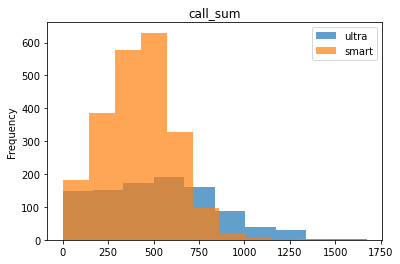

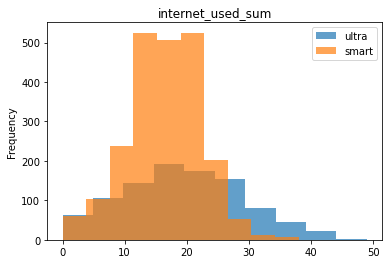

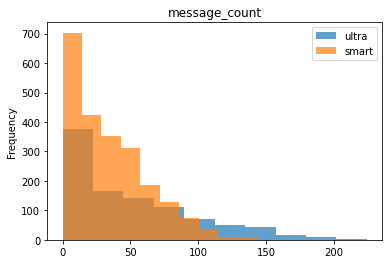

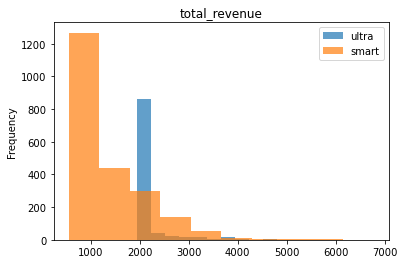

In [38]:
to_hist = ['call_sum', 'internet_used_sum', 'message_count', 'total_revenue']
for parametr in to_hist:
    ultra[parametr].plot(kind='hist', title=parametr, bins=10, alpha=0.7, label='ultra', legend=True)
    smart[parametr].plot(kind='hist', title=parametr, bins=10, alpha=0.7, label='smart', legend=True)
    plt.show()

По гистограммам вид распределения минут, сообщений и гигабайт похож на распределение Пуассона, что укрепляет веру в репрезентативность выборки и данных.  
По рассчитанным величинам средний пользователь тарифа **ultra** использует:
- 526 минут
- 19,5 Гб интернета
- 49 сообщений
- средняя выручка 2070 руб

По рассчитанным величинам средний пользователь тарифа **smart** использует:
- 418 минут
- 16,3 Гб интернета
- 33 сообщений 
- средняя выручка 1289 руб

Логично, что потребность в минутах, интернете и сообщениях выше у пользователей тарифа ultra, ведь тарифный план с большим количеством мин, Гб, сообщ. они вероятно выбирали исходя из своих потребностей, скорее всего рабочих.

## Проверка гипотез

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Тогда нулевая и альтернативная гипотезы будут сформулированы следующим образом:
- **H**0 **: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» равны**
- **H**1 **: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**

При этом **альтернативная гипотеза является двусторонней**, то есть отклонения в любую сторону при достататочном уровне статистической значимости будут учитываться и не будут противоречить алтренативной гипотезе.  
Для проверки нулевой гипотезы воспользуемся `st.ttest_ind` с параметром `equal_var=False`, так как выше была рассчитана дисперсия для каждой из выборок «Ультра» и «Смарт», они не были даже примерно равны.  
Критический уровень статистической значимости alpha установим согласно общей практике значением 0,05.

In [39]:
ultra_revenue = ultra['total_revenue']
smart_revenue = smart['total_revenue']
alpha = 0.05

In [40]:
results = st.ttest_ind(ultra_revenue, smart_revenue, equal_var=False)
print('p-значение:', results.pvalue)

p-значение: 4.2606313931076085e-250


In [41]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт»')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт»


**Резултат интрепретируется следующим образом:**  
Если бы гипотеза H0 была верна, то только в 4 из 1e+250 выборок средняя выручка тарифов смарт и ультра была бы равна. То есть это практически невозможно, даже если бы критический уровень был бы выбран ниже, все равно бы отвергли нулевую гипотезу.  
Как было рассчитано в прошлой части работы, средние выручки смарта и ультра равны 1289 и 2070 руб. соответсвенно, то есть явно видно, что они не равны и причем очень сильно.   
Статистический тест Уэлша (equal_var=False) в данном случае помог опровергнуть нулевую гипотезу.  
Поэтому мы отвергаем нулевую и при этом не отвергаем альтернативную двустороннюю гипотезу о том, что выручки не равны.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Чтобы проверить данную гипотезу, понадобится информация по месту жительства абонентов. Для этого создадим таблицу user_city, в которой будет user_id и city.  
Затем соединим таблицы user_city + revenue_table

In [42]:
user_city = users[['user_id', 'city']]

In [43]:
revenue_table_city = revenue_table.merge(user_city, on='user_id', how='left')

Далее подготовим списки прибыли от услуг сотовой связи москвичей и жителей остальных регионов.

In [44]:
moscow_revenue = revenue_table_city[revenue_table_city['city'] == 'Москва']['total_revenue']
not_moscow_revenue = revenue_table_city[~(revenue_table_city['city'] == 'Москва')]['total_revenue']

In [45]:
print('диспресия для выборки с московскими абонентами:', np.var(moscow_revenue, ddof=1))
print('диспресия для выборки с абонентами других регионов:',np.var(not_moscow_revenue, ddof=1))

диспресия для выборки с московскими абонентами: 565636.4670118879
диспресия для выборки с абонентами других регионов: 654137.6285218032


In [46]:
print('средняя выручка для выборки с московскими абонентами:', moscow_revenue.mean())
print('средняя выручка для выборки с абонентами других регионов:', not_moscow_revenue.mean())

средняя выручка для выборки с московскими абонентами: 1546.7135842880523
средняя выручка для выборки с абонентами других регионов: 1524.9362274298885


Тогда нулевая и альтернативная гипотезы будут сформулированы следующим образом:
- **H**0 **: Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов**
- **H**1 **: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

При этом альтернативная гипотеза является двусторонней, то есть отклонения в любую сторону при достататочном уровне статистической значимости будут учитываться и не будут противоречить алтренативной гипотезе.  
Для проверки нулевой гипотезы воспользуемся st.ttest_ind с параметром equal_var=True (по умолчанию), так как выше была рассчитана дисперсия для каждой из выборок Москвы и регионов, их можно признать хотя бы примерно равными, похожих порядков (ближе в случае с проверкой первой гипотезы).  
Критический уровень статистической значимости alpha установим согласно общей практике значением 0,05.

In [47]:
secondhypothesis = st.ttest_ind(moscow_revenue, not_moscow_revenue)
print('p-значение:', secondhypothesis.pvalue)
if secondhypothesis.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


**Резултат интрепретируется следующим образом:**  
Если гипотеза H0 верна, то в 54 из 100 выборок средняя выручка с московских и региональных пользователей будет равна.  
Значит, это более чем вероятно и нет оснований отвергать нулевую гипотезу.   
Статистический тест Стьдента в данном случае не опроверг нулевую гипотезу.  
Поэтому мы отвергаем альтернативную двустороннюю гипотезу о том, что выручки не равны (нет оснований).

## Вывод

В рамках данной работы был проведен статистический анализ данных.  
**В 3 разделе работы были рассчитаны показатели для тарифов смарт и ультра:**  

По рассчитанным величинам средний пользователь тарифа ultra использует:  
515 минут  
19,6 Гб интернета  
62 сообщения  
средняя выручка 2070 руб  

По рассчитанным величинам средний пользователь тарифа smart использует:  
396 минут  
16,3 Гб интернета  
39 сообщений  
средняя выручка 1258 руб  

**В 4 разделе были проверены 2 гипотезы:**
1) В результате проверки - отвергаем нулевую гипотезу о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт».   
Как было рассчитано в прошлой части работы, средние выручки смарта и ультра равны 1289 и 2070 руб. соответсвенно, то есть явно видно, что они не равны и причем очень сильно.  

2) В результате проверки - не получилось отвергнуть нулевую гипотезу о равенстве срединей прибыли с московских и региональных абонентов.  
Средняя выручка для выборки с московскими абонентами: 1546 руб.  
Средняя выручка для выборки с абонентами других регионов: 1524 руб.  
Разница средних не столь существенна, при этом p-value в районе 54% не позволил опровергнуть гипотезу о равентсве.

**Какой тариф более выгодный для оператора связи?**  
Если отталкиваться от средней выручки с каждого абонента, то **более выгодным тарифом для оператора связи является тариф ultra**, ведь при схожих порядках количества звонков, интернета и сообщений, выручка выше примерно в полтора раза.  
Но для однозначного ответа на данный вопрос необходимы дополнительные данные, например сколько одна минута звонка стоит для самого оператора связи. То же самое про интернет и сообщения.  
Тариф ultra более выгодный за счет своей абонентской платы.  
Поэтому можно корректировать рекламный бюджет в сторону увеличения средств на рекламу тарифа ultra.
Но при этом понимать, что только 30% от общего количества абонентов выборки (149 абонентов) имеют тариф 'ultra' и поэтому общая прибыль в выборке с тарифом ultra - 308430 руб, а с тарифом smart - 441558 руб.   
Поэтому тариф ultra выгоднее (без исследования доп.информации), а денег в общем приносит больше тариф smart за счет более высокого охвата.